# Unit 1 Project- Buffalo 311 Open Data Analysis
---
DAT 512 Canisuis College <br>
Zachary Lundy<br>
<br>
### Learning Objectives
---
To allow students to demonstrate the following competencies:

- Ability to bring data from multiple sources into a single environment
- Ability to manipulate and combine data in order to further process
- Knowledge of a forecasting process and ability to create and evaluate an ARIMA forecast
### Sections
- [Open Buffalo API](#open_buffalo_api)
- [Prophet](#Prophet)
- [Holidays](#Holidays)
- [ARIMA Prep](#ARIMA_Prep)
- [Auto ARIMA](#Auto_ARIMA)
- [EDA Visuals & Data Models](#EDA_Visuals_&_Data_Models)


In [ ]:
# Run first time only to install prophet
!pip install prophet

In [1]:
# Import Required Packages
import pandas as pd
import numpy as np
import requests
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from prophet import Prophet
import matplotlib.pyplot as plt
 
%matplotlib inline
 
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

<a id='open_buffalo_api'></a>
# Read in Buffalo 311 Data

In [2]:
#API for the 311 Buffalo Data
#Selecting 2012-2022 as years
#Limiting to 1,000,000 rows
params_dict_311 = {
    '$where':"date_extract_y(open_date)>=2012 and date_extract_y(open_date)<2023",
    '$limit':1000000
}

uri_311 = 'https://data.buffalony.gov/resource/whkc-e5vr.json'

r_311 =requests.get(uri_311,params=params_dict_311)
print('Status code:',r_311.status_code)
print('Number of rows returned:',len(r_311.json()))
print('Endoced URI with params:',r_311.url)

Status code: 200
Number of rows returned: 823366
Endoced URI with params: https://data.buffalony.gov/resource/whkc-e5vr.json?%24where=date_extract_y%28open_date%29%3E%3D2012+and+date_extract_y%28open_date%29%3C2023&%24limit=1000000


In [3]:
calls311=pd.DataFrame(r_311.json())
calls311.head()

,case_reference,open_date,closed_date,status,subject,reason,type,object_type,address_number,address_line_1,...,x_coordinate,y_coordinate,census_tract_2010,census_block_group_2010,census_block_2010,tractce20,geoid20_tract,geoid20_blockgroup,geoid20_block,address_line_2
0,1001756978,2022-12-27T12:02:00.000,2023-01-06T16:49:00.000,Closed,Dept of Public Works,Streets,Street Snow Plowing (Req_Serv),Property,235,SHERMAN,...,-8777167.282,5295234.3467,15,2,2002,001500,36029001500,360290015002,360290015002002,NaN
1,1001353407,2021-02-23T10:29:00.000,2023-03-25T11:19:00.000,Closed,Dept of Public Works,Engineering - Traffic,Signal Out or Flashing (Req_Serv),Property,INTERSECTION,W Delavan Ave,...,1072928.6,1064870.4,169,4,4004,016900,36029016900,360290169004,360290169004006,Linwood Ave
2,1001339938,2021-02-09T14:36:00.000,2023-01-02T17:20:00.000,Closed,Dept of Public Works,Engineering - Traffic,Sign Maintenance (Req_Serv),Property,INTERSECTION,Forest Ave,...,1072174.2,1066985.6,53,2,2006,005300,36029005300,360290053002,360290053002003,Delaware Ave
3,1001759464,2022-12-29T14:44:00.000,2023-01-13T11:13:00.000,Closed,Dept of Public Works,Animal Shelter,Animals (Req_Serv),Street,NaN,N Ogden St,...,NaN,NaN,2,4,4001,000200,36029000200,360290002004,360290002004001,NaN
4,1001757568,2022-12-27T16:32:00.000,2023-01-03T11:08:00.000,Closed,Dept of Public Works,Sanitation,Totes Replace (Req_Serv),Property,92,KILHOFFER,...,-8773870.998,5298881.8567,36,3,3000,003600,36029003600,360290036003,360290036003000,NaN


In [4]:
#Remove time from datetime
calls311["Date"] = pd.to_datetime(calls311["open_date"]).dt.date

In [5]:
#Subset data needed for Prophet
callDate = calls311[["Date", "status"]]

In [6]:
callcount = callDate.groupby("Date").count()

In [7]:
calls=pd.DataFrame(callcount).reset_index()

In [8]:
#Rename columns for Prophet
calls = calls.rename(columns={'Date':'ds', 'status':'y'})
calls.head()

,ds,y
0,2012-01-01,5
1,2012-01-02,7
2,2012-01-03,183
3,2012-01-04,253
4,2012-01-05,176


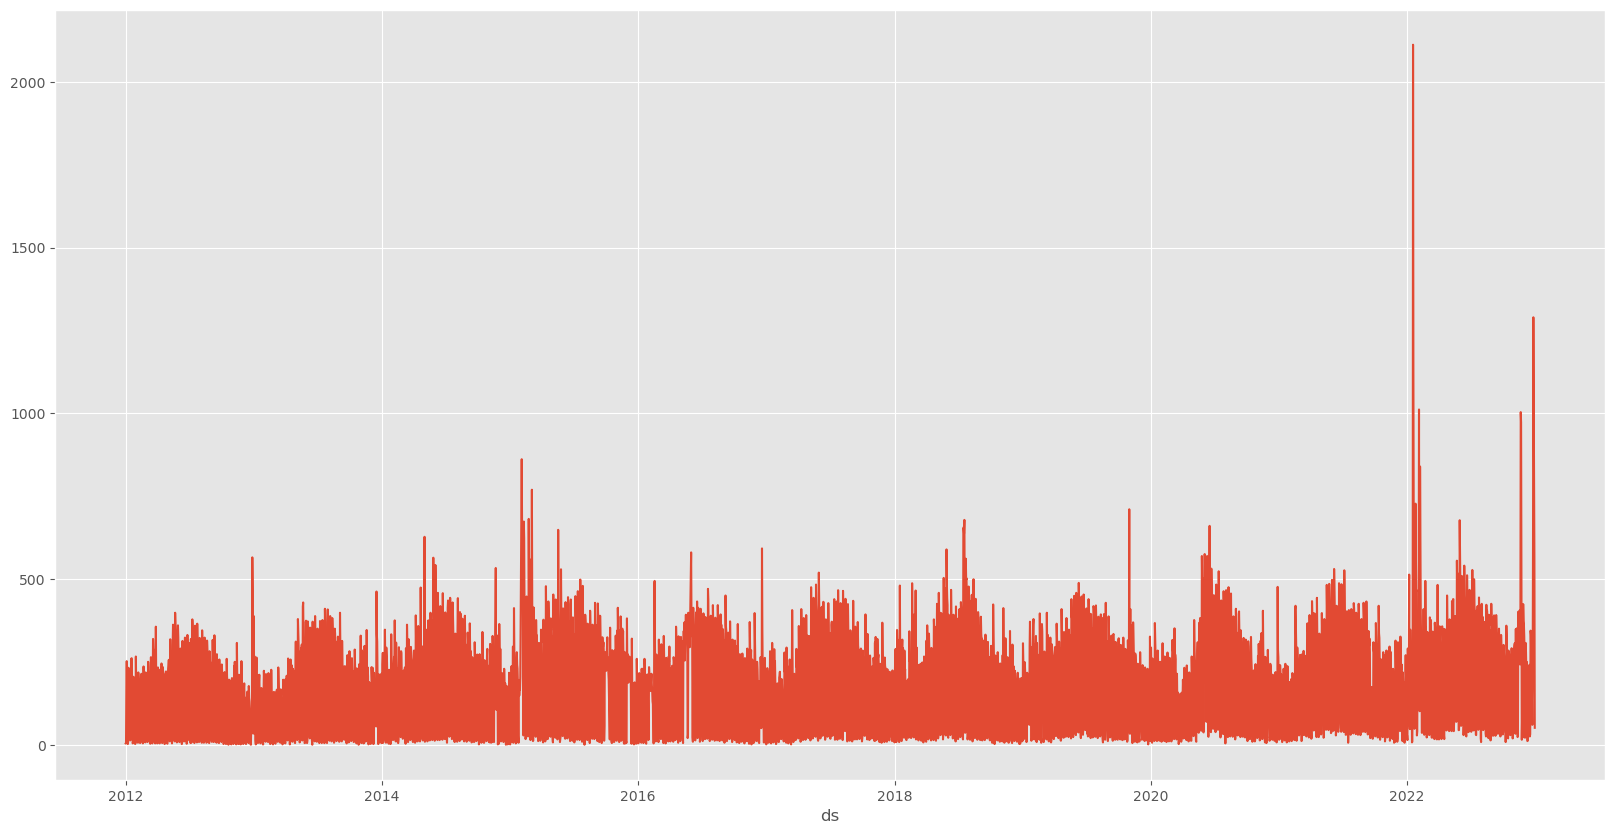

In [9]:
# Prophet doesn't require the date ('ds') to be in the index, but df.plot() so we add .set_index('ds')
calls.set_index('ds').y.plot();

<a id='Prophet'></a>
# Prophet

In [10]:
# Instantiate Model
model = Prophet()

# Fit Model
model.fit(calls)

23:36:14 - cmdstanpy - INFO - Chain [1] start processing
23:36:15 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
# Create future data frame
future = model.make_future_dataframe(periods=365, freq='D')
future.tail()

,ds
4348,2023-12-27
4349,2023-12-28
4350,2023-12-29
4351,2023-12-30
4352,2023-12-31


In [12]:
# Add predictions to the forecast dataframe
forecast = model.predict(future)

In [13]:
forecast.tail().T

,4348,4349,4350,4351,4352
ds,2023-12-27 00:00:00,2023-12-28 00:00:00,2023-12-29 00:00:00,2023-12-30 00:00:00,2023-12-31 00:00:00
trend,311.5078,311.59871,311.689619,311.780529,311.871438
yhat_lower,224.959362,209.57145,188.696581,-34.086007,-40.030974
yhat_upper,437.475438,425.071102,411.716232,191.489594,196.188209
trend_lower,302.827727,302.890493,302.963444,303.041784,303.120123
trend_upper,319.268719,319.39632,319.532962,319.665687,319.784786
additive_terms,20.140554,10.405563,-12.142427,-237.249234,-232.045569
additive_terms_lower,20.140554,10.405563,-12.142427,-237.249234,-232.045569
additive_terms_upper,20.140554,10.405563,-12.142427,-237.249234,-232.045569
weekly,74.361729,63.685501,40.162402,-185.958813,-181.814802


In [14]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4348,2023-12-27,331.648354,224.959362,437.475438
4349,2023-12-28,322.004272,209.571450,425.071102
4350,2023-12-29,299.547192,188.696581,411.716232
4351,2023-12-30,74.531295,-34.086007,191.489594
4352,2023-12-31,79.825869,-40.030974,196.188209


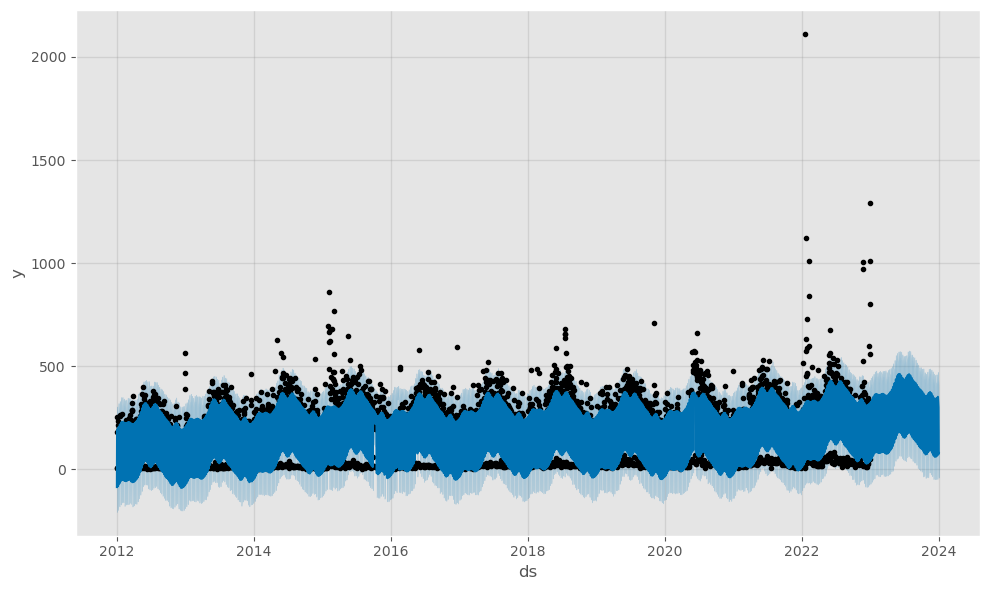

In [15]:
# Plot the forecast
model.plot(forecast);

In [16]:
#To do this, we have to get the y-hat and original y's from the data
metric_df = pd.concat([forecast[['ds','yhat']],calls['y']], axis=1)
metric_df.head()

,ds,yhat,y
0,2012-01-01,-85.942404,5.0
1,2012-01-02,191.041647,7.0
2,2012-01-03,193.959000,183.0
3,2012-01-04,174.055147,253.0
4,2012-01-05,164.787589,176.0


In [17]:
# check the tail, because we added 24 months of forecast.
metric_df.tail()

,ds,yhat,y
4348,2023-12-27,331.648354,NaN
4349,2023-12-28,322.004272,NaN
4350,2023-12-29,299.547192,NaN
4351,2023-12-30,74.531295,NaN
4352,2023-12-31,79.825869,NaN


In [18]:
# The tail has NaN values, because they're predictions - there was no real Y. Let's drop those for model evaluation.
metric_df.dropna(inplace = True)

In [19]:
#Let's take a look at the numbers - from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
print("R-squared: ", r2_score(metric_df['y'], metric_df['yhat']))
print("Mean Squared Error: ", mean_squared_error(metric_df['y'], metric_df['yhat']))
print("RMSE: ", np.sqrt(mean_squared_error(metric_df['y'], metric_df['yhat'])))

R-squared:  0.6760054568002452
Mean Squared Error:  7722.645450464514
RMSE:  87.87858357110971


## 67% of the variability covered by this model in number of 311 calls

<a id='Holidays'></a>
# Holidays

In [20]:
from datetime import date

import holidays

# Select country

us_holidays = holidays.UnitedStates(years = [2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022])

holidays = pd.DataFrame({
    'holiday': us_holidays.values(),
    'ds': us_holidays.keys(),
    'lower_window': 0,
    'upper_window': 0,

}) 

holidays

,holiday,ds,lower_window,upper_window
0,New Year's Day,2016-01-01,0,0
1,Martin Luther King Jr. Day,2016-01-18,0,0
2,Washington's Birthday,2016-02-15,0,0
3,Memorial Day,2016-05-30,0,0
4,Independence Day,2016-07-04,0,0
...,...,...,...,...
121,Labor Day,2015-09-07,0,0
122,Columbus Day,2015-10-12,0,0
123,Veterans Day,2015-11-11,0,0
124,Thanksgiving,2015-11-26,0,0


In [21]:
#Now let's set up prophet to model our data using holidays - Instantiate and fit the model
model = Prophet(holidays=holidays,
                yearly_seasonality=True
                )

#model.add_seasonality(name='yearly', period=10, fourier_order=10)
model.fit(calls)

23:36:17 - cmdstanpy - INFO - Chain [1] start processing
23:36:18 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
#We've instantiated the model, so now we need to build our future dates to forecast into!
future = model.make_future_dataframe(periods=365, freq='D')
future.tail()

#... and then run our future data through prophet's model
forecast = model.predict(future)

forecast.head().T

,0,1,2,3,4
ds,2012-01-01 00:00:00,2012-01-02 00:00:00,2012-01-03 00:00:00,2012-01-04 00:00:00,2012-01-05 00:00:00
trend,156.540595,156.56481,156.589025,156.613239,156.637454
yhat_lower,-317.962791,-106.063064,121.680379,103.446259,92.221417
yhat_upper,-124.230506,94.560914,315.875997,284.979721,288.518392
trend_lower,156.540595,156.56481,156.589025,156.613239,156.637454
...,...,...,...,...,...
yearly_upper,-31.556721,-30.1862,-29.03057,-28.07658,-27.306468
multiplicative_terms,0.0,0.0,0.0,0.0,0.0
multiplicative_terms_lower,0.0,0.0,0.0,0.0,0.0
multiplicative_terms_upper,0.0,0.0,0.0,0.0,0.0


In [23]:
#while our new df contains a bit of data, we only care about a few features...
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4348,2023-12-27,348.370978,246.352086,446.896650
4349,2023-12-28,344.257845,251.111392,441.688508
4350,2023-12-29,321.582248,225.477637,421.866144
4351,2023-12-30,94.616605,-6.511599,208.587722
4352,2023-12-31,100.845798,6.910625,204.118796


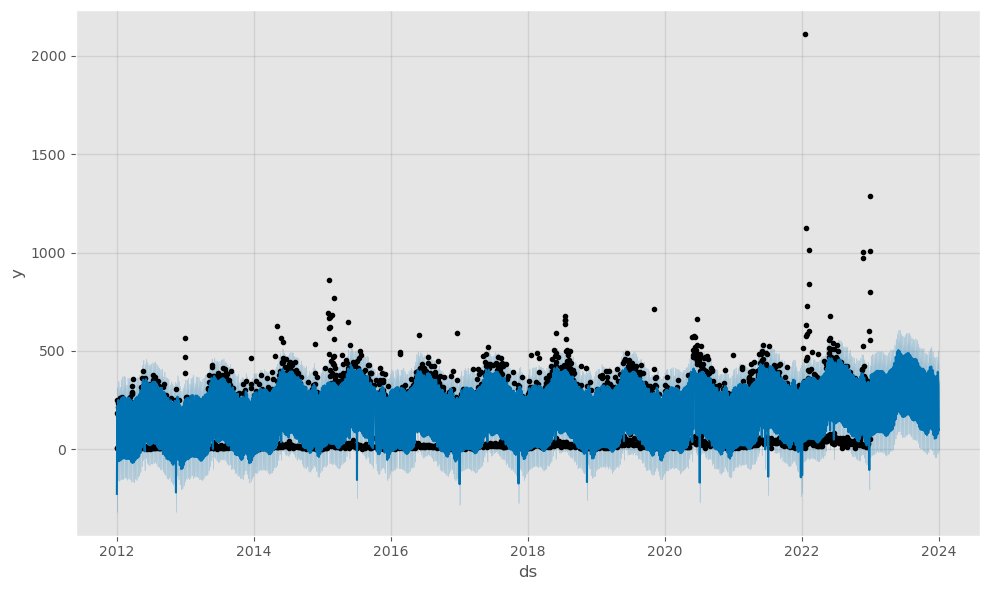

In [24]:
# use Prophet's .plot() method to visualize your timeseries.
model.plot(forecast);

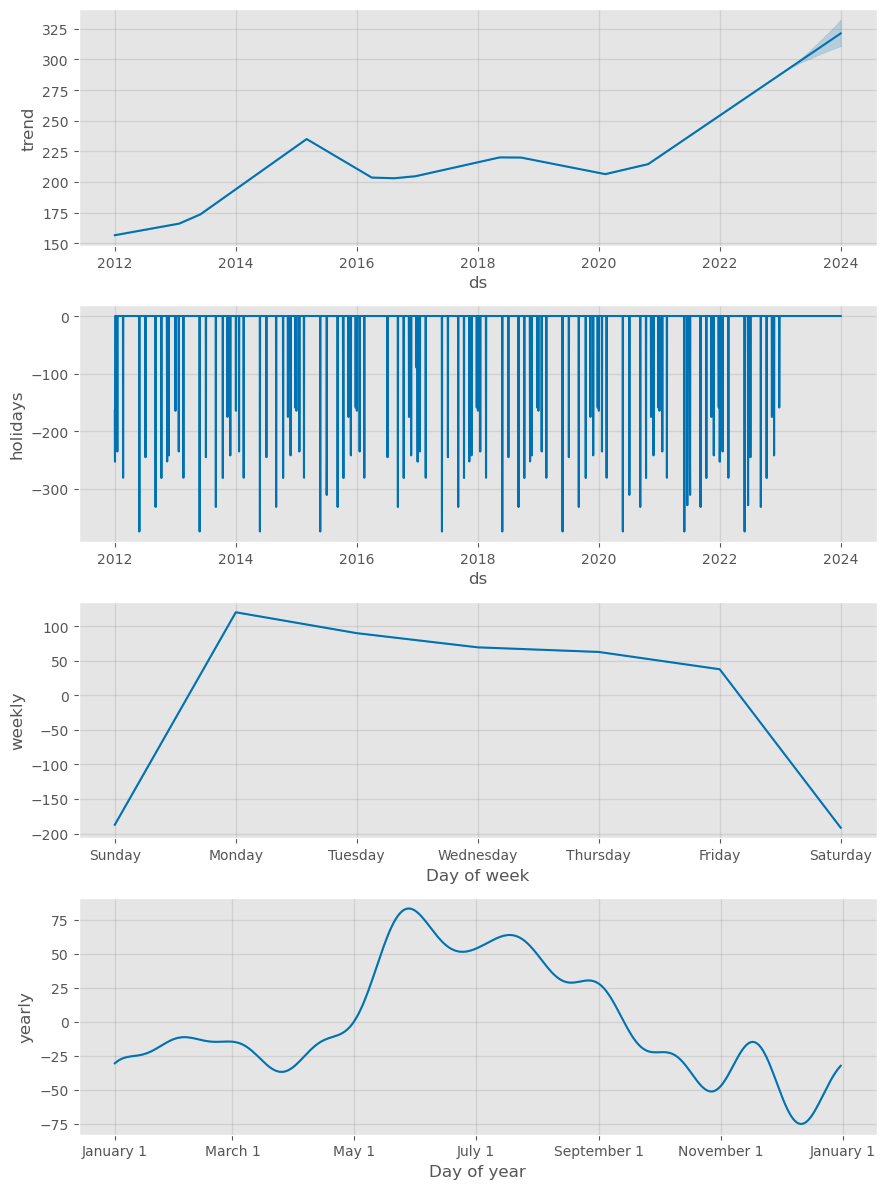

In [25]:
# View the components
model.plot_components(forecast);

## Seems like holidays may lead to lower call volume, same for weekends

In [26]:
holiday_df = pd.concat([forecast[['ds','yhat']],calls['y']], axis=1)

In [27]:
holiday_df.dropna(inplace = True)

In [28]:
#Let's take a look at the numbers - from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
print("R-squared: ", r2_score(holiday_df['y'], holiday_df['yhat']))
print("Mean Squared Error: ", mean_squared_error(holiday_df['y'], holiday_df['yhat']))
print("RMSE: ", np.sqrt(mean_squared_error(holiday_df['y'], holiday_df['yhat'])))

R-squared:  0.7509950049932934
Mean Squared Error:  5935.21505899528
RMSE:  77.04034695531479


In [29]:
holiday_df.head()

,ds,yhat,y
0,2012-01-01,-226.686129,5.0
1,2012-01-02,-6.616476,7.0
2,2012-01-03,217.256263,183.0
3,2012-01-04,197.726452,253.0
4,2012-01-05,191.871742,176.0


In [30]:
model_no_holiday = Prophet()
model_no_holiday.fit(calls)

23:36:20 - cmdstanpy - INFO - Chain [1] start processing
23:36:21 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
future_no_holiday = model_no_holiday.make_future_dataframe(periods=365)
future_no_holiday.tail()

,ds
4348,2023-12-27
4349,2023-12-28
4350,2023-12-29
4351,2023-12-30
4352,2023-12-31


In [32]:
forecast_no_holiday = model_no_holiday.predict(future)

In [33]:
#join the dataframes
forecast.set_index('ds', inplace=True)
forecast_no_holiday.set_index('ds', inplace=True)
compared_df = forecast.join(forecast_no_holiday, rsuffix="_no_holiday")

In [34]:
#we're only interested in the predictions, and let's move back to the original scale
compared_df = compared_df[['yhat', 'yhat_no_holiday']]
compared_df.head()

,yhat,yhat_no_holiday
ds,,
2012-01-01,-226.686129,-85.942404
2012-01-02,-6.616476,191.041647
2012-01-03,217.256263,193.959000
2012-01-04,197.726452,174.055147
2012-01-05,191.871742,164.787589


In [35]:
# Create a feature that is the percentage difference between holiday vs. none
compared_df['diff_per'] = 100 * (compared_df['yhat'] - compared_df['yhat_no_holiday']) / compared_df['yhat_no_holiday']
print("difference: ", round(compared_df.diff_per.mean(), 2), "%")

difference:  4.73 %


## 4.7% increase in varaibility covered by model when accounting for holidays

<a id='ARIMA_Prep'></a>
# ARIMA Prep

In [36]:
callcount = callDate.groupby("Date").count()

In [37]:
callsARIMA=pd.DataFrame(callcount).reset_index()
callsARIMA["Date"]= pd.to_datetime(callsARIMA['Date'])
callsARIMA.set_index('Date',inplace = True)

In [38]:
#Test last year of data to see how accurate model is
train = callsARIMA.loc['2012':'2021']
test = callsARIMA.loc['2022']

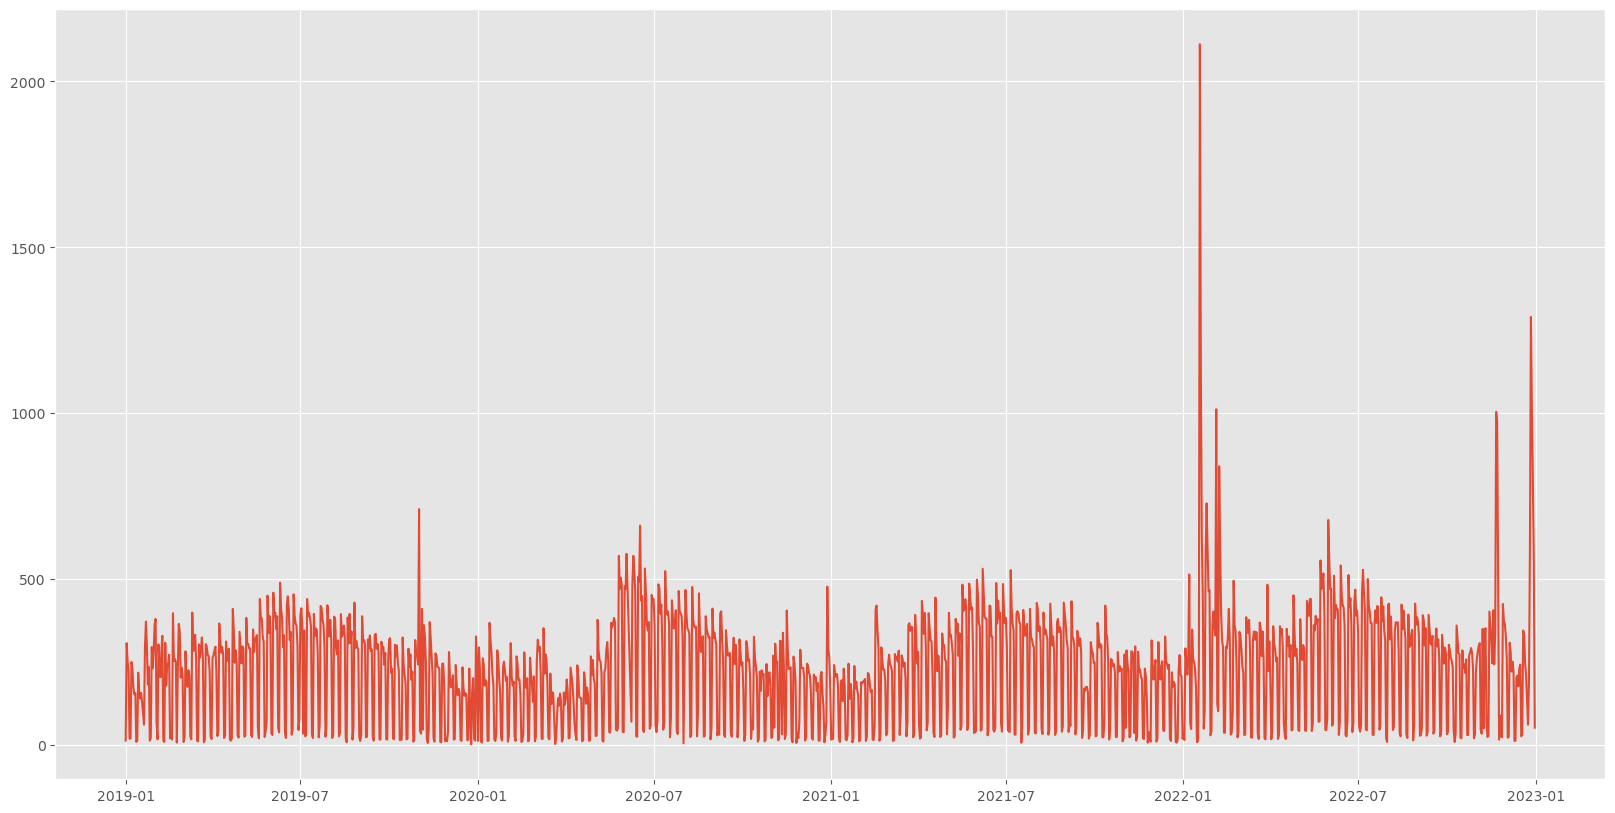

In [39]:
plt.plot(callsARIMA.loc["2019":"2022"])

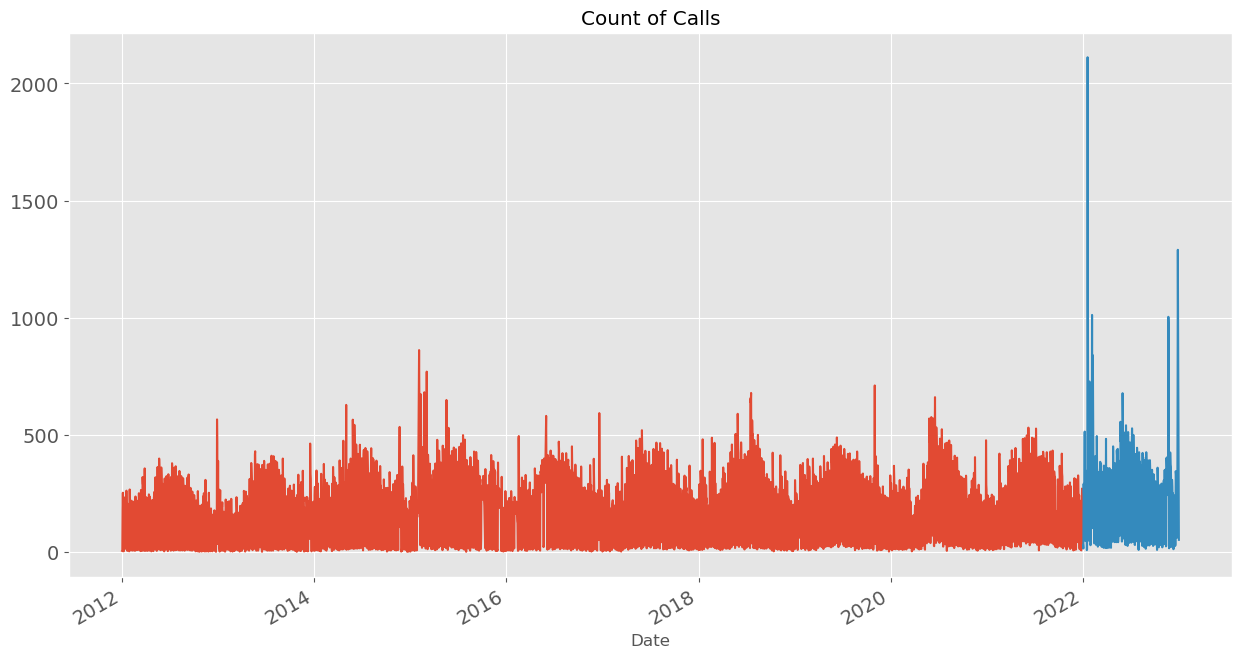

In [40]:
train.status.plot(figsize=(15,8), title= 'Count of Calls', fontsize=14)
test.status.plot(figsize=(15,8), title= 'Count of Calls', fontsize=14)
plt.show()

In [41]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [42]:
! pip install pmdarima

In [43]:
from pmdarima.arima import auto_arima

In [44]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(callsARIMA)

(0.01, False)

Data is non-stationary

<a id='Auto_ARIMA'></a>
# Auto ARIMA

In [45]:
arima_model = auto_arima(train, trace = True,
supress_warnings=True, stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=44861.310, Time=3.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=47152.898, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=47104.729, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=46039.724, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=47150.898, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=45395.060, Time=1.59 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=45198.062, Time=1.76 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.75 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=44196.961, Time=6.45 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=45067.637, Time=2.62 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=44862.429, Time=6.33 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=44238.243, Time=7.17 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=4.86 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=6.71 sec
 ARIMA(2,1,3)(0,0,0)[0]             :

## Best model:  ARIMA(2,1,3)(0,0,0)[0]  

In [46]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3623
Model:               SARIMAX(2, 1, 3)   Log Likelihood              -22034.122
Date:                Wed, 10 May 2023   AIC                          44080.245
Time:                        23:37:42   BIC                          44117.413
Sample:                             0   HQIC                         44093.487
                               - 3623                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2438      0.001    860.088      0.000       1.241       1.247
ar.L2         -1.0000   4.92e-05  -2.03e+04      0.000      -1.000      -1.000
ma.L1         -2.1277      0.008   -261.739      0.000      -2.144      -2.112
ma.L2          2.0086      0.014    147.735      0.000       1.982       2.035
ma.L3         -0.8348      0.008   -101.805      0.000      -0.851      -0.819
sigma2      1.132e+04    202.621     55.881      0.000    1.09e+04    1.17e+04
===================================================================================
Ljung-Box (L1) (Q):                   2.42   Jarque-Bera (JB):               776.47
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.74
Prob(H) (two-sided):                  0.92   Kurtosis:                         4.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
callsARIMA.index=pd.to_datetime(callsARIMA.index)

In [48]:
callsARIMA.head()

,status
Date,
2012-01-01,5
2012-01-02,7
2012-01-03,183
2012-01-04,253
2012-01-05,176


In [49]:
train = callsARIMA.loc['2012':'2021'].copy()
test = callsARIMA.loc['2022'].copy()

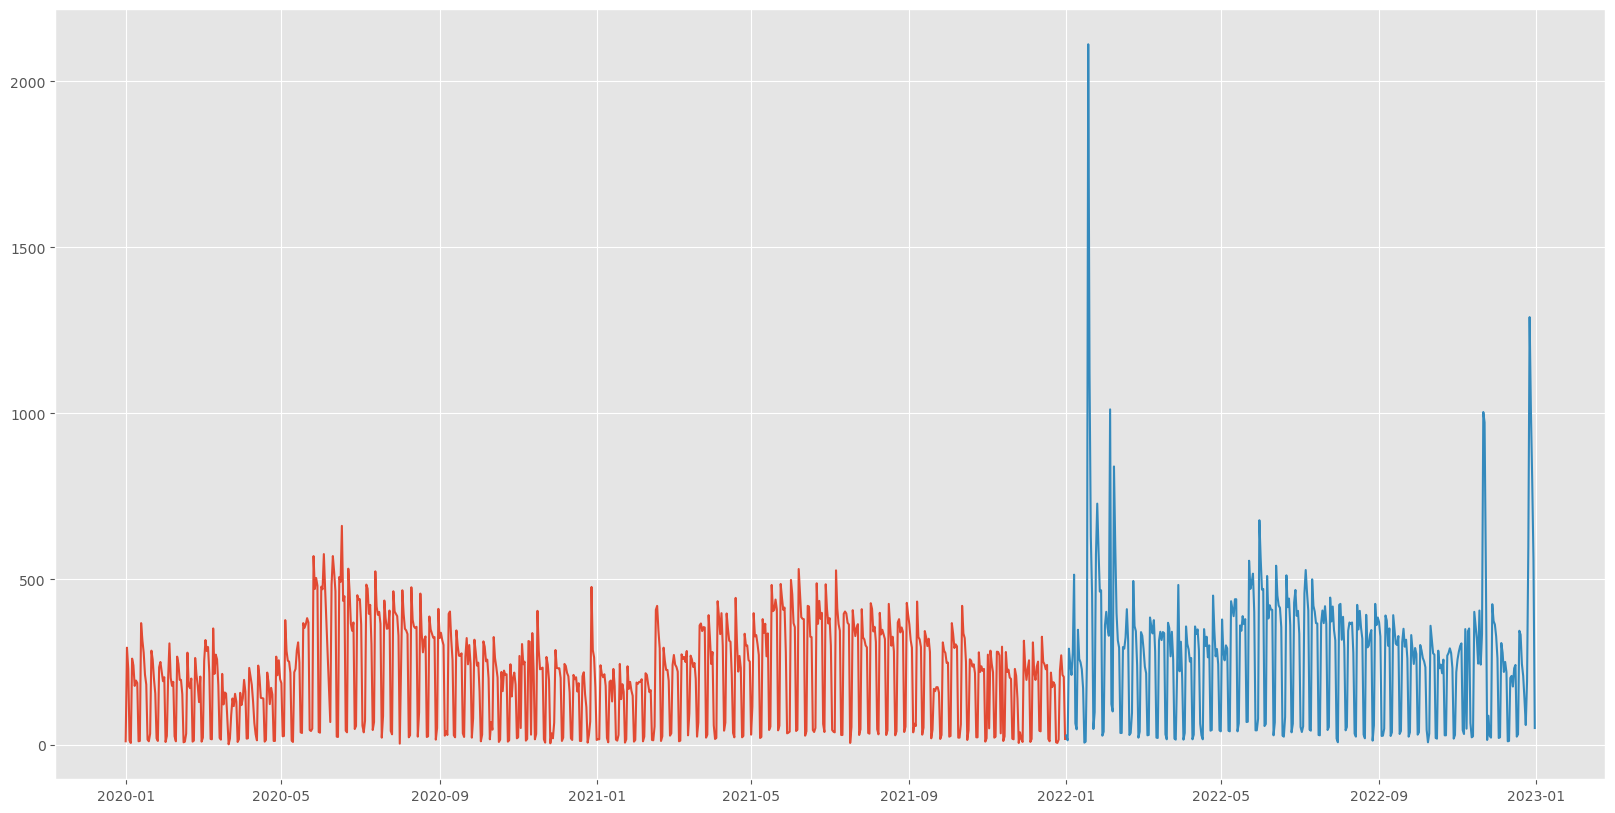

In [50]:
plt.plot(train.loc["2020":"2021"])
plt.plot(test)

In [51]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [52]:
model=sm.tsa.ARIMA(callsARIMA['status'], order=(2,1,3))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 status   No. Observations:                 3988
Model:                 ARIMA(2, 1, 3)   Log Likelihood              -24626.852
Date:                Wed, 10 May 2023   AIC                          49265.705
Time:                        23:37:46   BIC                          49303.449
Sample:                             0   HQIC                         49279.086
                               - 3988                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2461      0.001   1064.538      0.000       1.244       1.248
ar.L2         -0.9999   9.78e-05  -1.02e+04      0.000      -1.000      -1.000
ma.L1         -2.1042      0.007   -296.921      0.000      -2.118      -2.090
ma.L2          2.0087      0.011    186.455      0.000       1.988       2.030
ma.L3         -0.8191      0.007   -109.989      0.000      -0.834      -0.805
sigma2      1.545e+04    129.175    119.589      0.000    1.52e+04    1.57e+04
===================================================================================
Ljung-Box (L1) (Q):                   3.92   Jarque-Bera (JB):             60546.04
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               1.50   Skew:                             1.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start, end=end, typ='levels')
pred.index=callsARIMA.index[start:end+1]
print(pred)

Date
2022-01-01     38.182678
2022-01-02     71.854053
2022-01-03    149.923293
2022-01-04    245.374691
2022-01-05    242.295881
                 ...    
2022-12-27    374.349402
2022-12-28    474.657010
2022-12-29    389.571775
2022-12-30    280.212052
2022-12-31    267.639165
Name: predicted_mean, Length: 365, dtype: float64


<AxesSubplot:xlabel='Date'>

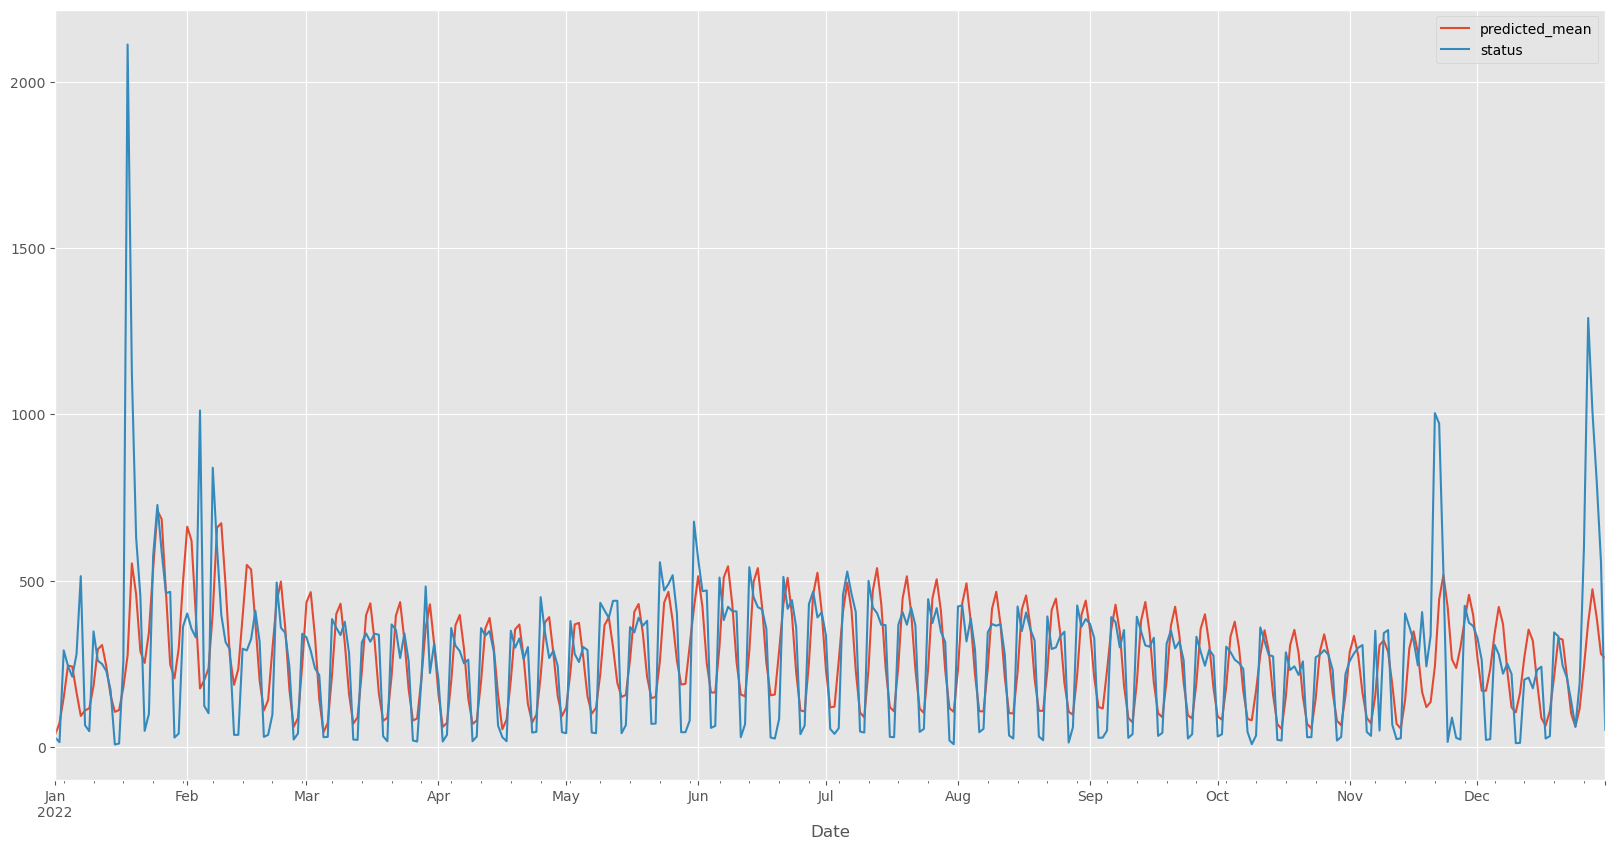

In [54]:
pred.plot(legend=True)
test['status'].plot(legend=True)

In [55]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred, test['status']))
rmse

180.3192898597127

## Model could be overfit, high RMSE compared to above. However, COVID and snow could account for some varaibility. Would be interesting to see how 2023's winter compares.

In [56]:
model2023 = sm.tsa.ARIMA(callsARIMA['status'], order=(2,1,3))
model2023 = model2023.fit()


## 2023 Predicition

In [57]:
dates2023 = pd.date_range(start="2023-01-01", end="2023-12-31")
start = len(callsARIMA)
end = len(callsARIMA)+len(dates2023)-1
pred2023=model2023.predict(start=start, end=end, typ='levels')
pred2023.index=dates2023
print(pred2023)

2023-01-01    339.026069
2023-01-02    541.946804
2023-01-03    684.428094
2023-01-04    659.058437
2023-01-05    484.972159
                 ...    
2023-12-27    627.987653
2023-12-28    437.868992
2023-12-29    265.793563
2023-12-30    241.485608
2023-12-31    383.263047
Freq: D, Name: predicted_mean, Length: 365, dtype: float64


<AxesSubplot:>

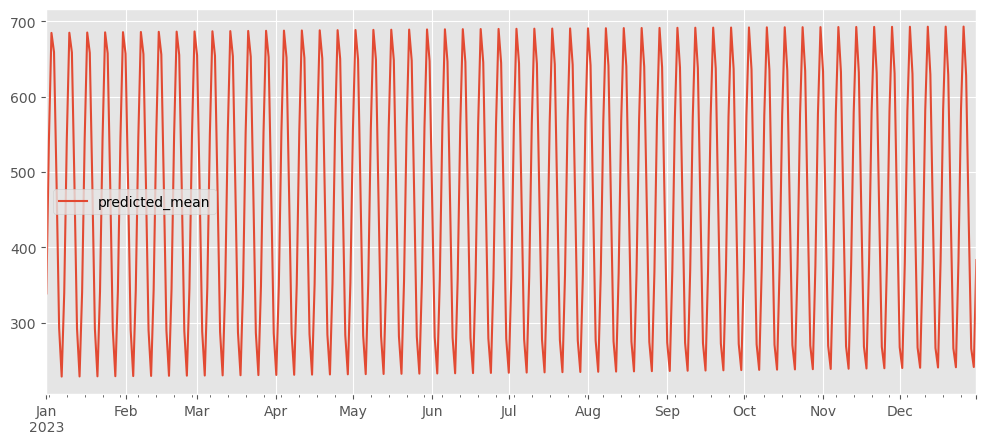

In [58]:
pred2023.plot(figsize=(12,5),legend=True)